# Bayesian Machine Learning Coursework 4

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, spatial
import lab4_hmc as hmc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.05)

## Task 1 - Exploratory analysis

1. Undertake an initial exploratory analysis of the training data and summarise. [5 marks]

In [2]:
# Loading the data
train = pd.read_csv('ee-train.csv')
test = pd.read_csv('ee-test.csv')

In [3]:
# Checking for null values
print('Any null values in the train set?:', train.isnull().values.any())
print('Any null values in the test set?:', test.isnull().values.any())

# Showing the first 10 rows just to check how the values are represented
train.head(10)

Any null values in the train set?: False
Any null values in the test set?: False


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.62,808.5,367.5,220.50,3.5,3,0.10,5,12.74
1,0.90,563.5,318.5,122.50,7.0,3,0.10,2,29.68
2,0.90,563.5,318.5,122.50,7.0,3,0.40,2,36.57
3,0.79,637.0,343.0,147.00,7.0,2,0.25,2,38.57
4,0.90,563.5,318.5,122.50,7.0,4,0.40,5,34.72
5,0.64,784.0,343.0,220.50,3.5,2,0.25,4,16.99
6,0.64,784.0,343.0,220.50,3.5,3,0.10,4,15.19
7,0.98,514.5,294.0,110.25,7.0,3,0.25,3,28.56
8,0.71,710.5,269.5,220.50,3.5,2,0.40,1,14.51
9,0.86,588.0,294.0,147.00,7.0,5,0.10,1,25.27


In [4]:
# Describing the general statistics of the feature columns
train.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.771042,665.774740,318.180990,173.796875,5.377604,3.536458,0.236849,2.783854,22.920703
std,0.106553,88.196712,42.248972,44.852410,1.747619,1.097695,0.133306,1.567506,10.066099
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.400000
25%,0.690000,588.000000,294.000000,140.875000,3.500000,3.000000,0.100000,1.000000,14.057500
50%,0.760000,661.500000,318.500000,147.000000,7.000000,4.000000,0.250000,3.000000,23.605000
75%,0.860000,735.000000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000,32.052500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000


In [5]:
# Splitting train data to x and target datasets
y_train = train['Heating Load']
x_train = train.loc[:, train.columns != 'Heating Load']

# Splitting test data to x and target datasets
y_test = test['Heating Load']
x_test = test.loc[:, test.columns != 'Heating Load']

# Standardizing the x datasets
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

print('Train data:', x_train.shape, y_train.shape)
print('Test data:', x_test.shape, y_test.shape)

Train data: (384, 8) (384,)
Test data: (384, 8) (384,)


In [6]:
# Combining back the standardized columns with the target column
train_stand = pd.concat([x_train, y_train], axis=1)

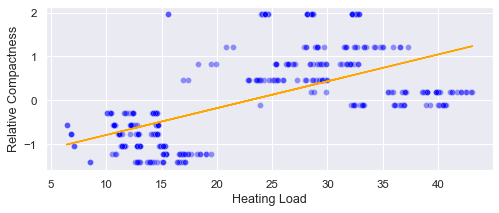

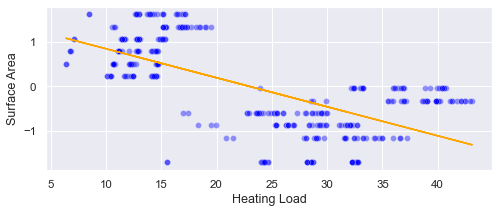

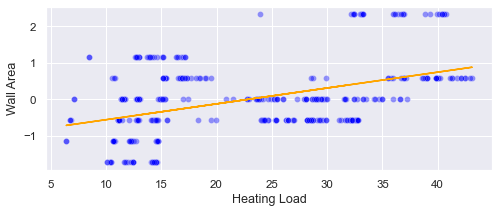

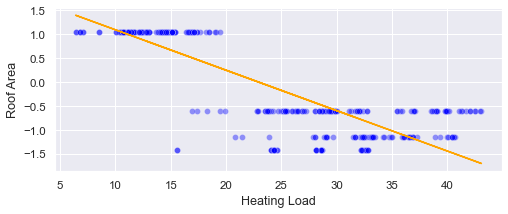

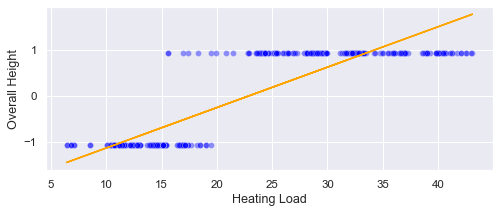

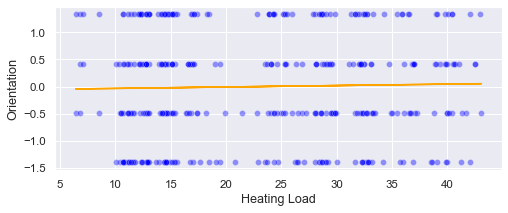

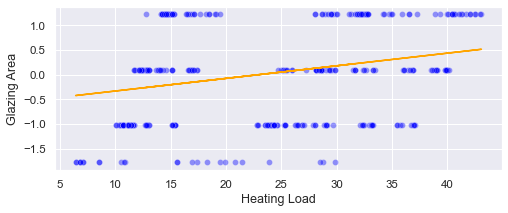

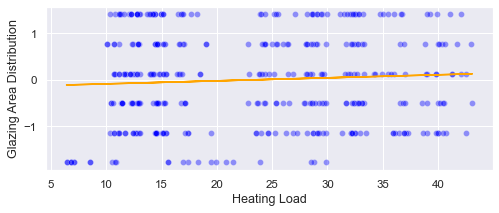

In [7]:
feature_columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 
                   'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']

# Plotting all features against the Target Column
for feature in feature_columns:

    plt.figure(figsize=(8, 3))
    sns.scatterplot(data=train_stand, x='Heating Load', y=feature, color='blue', alpha=0.4)
    
    # https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python
    # Plotting line of best fit on data in the scatter plot
    m, b = np.polyfit(train_stand['Heating Load'], train_stand[feature], 1)
    plt.plot(train_stand['Heating Load'], m*train_stand['Heating Load'] + b, color='orange')
    plt.xlabel('Heating Load')
    plt.ylabel(feature)
    plt.show()


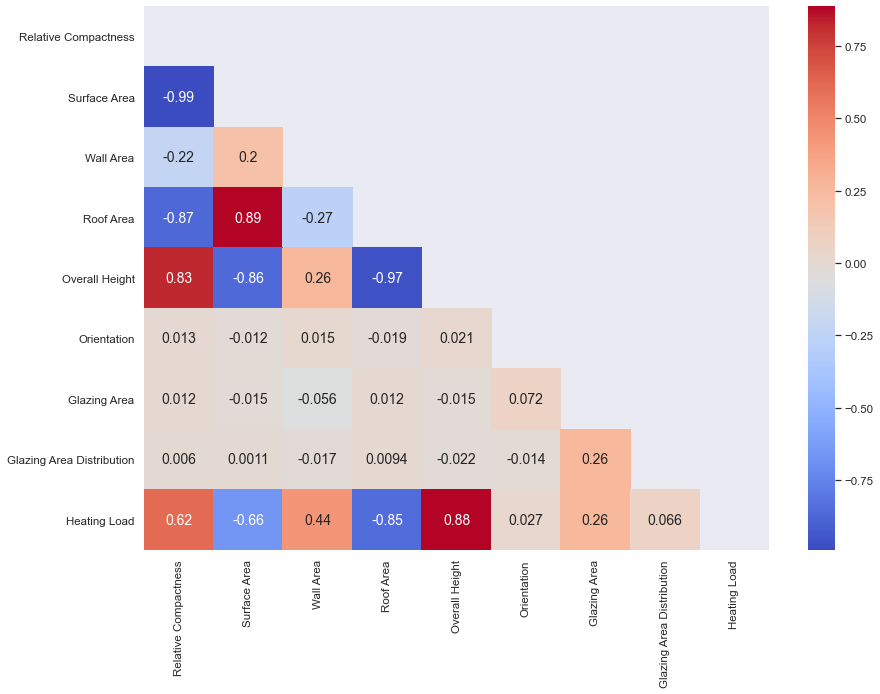

In [8]:
plt.figure(figsize=(14, 10))

# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
mask = np.triu(np.ones_like(train_stand.corr(), dtype=np.bool))

# Plotting a correlation heatmap using a mask to hide the upper diagonal part as it provides no extra information
heatmap = sns.heatmap(train_stand.corr(), mask=mask, annot=True, cmap='coolwarm',annot_kws={'size':14})

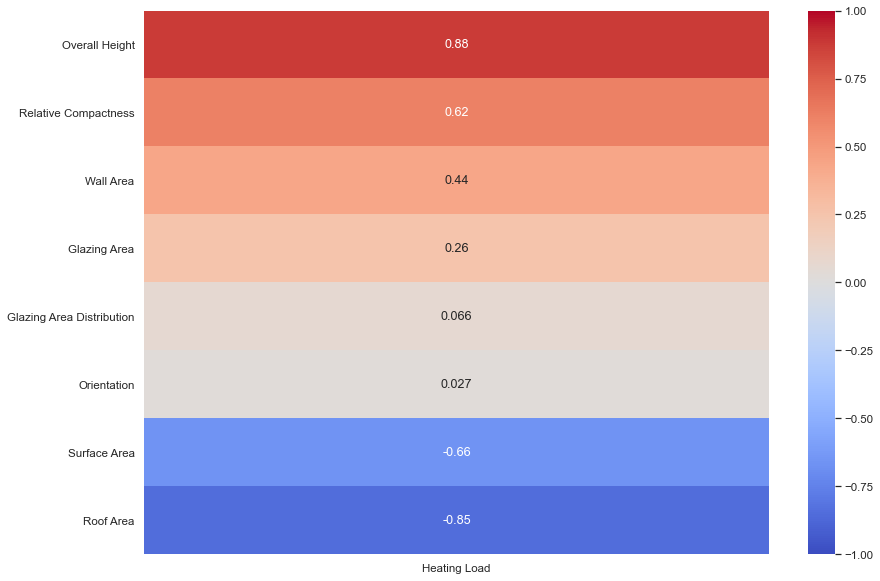

In [9]:
plt.figure(figsize=(14, 10))
# Identifying the most correlated features in respect to the target feature
heatmap = sns.heatmap(train_stand.corr()[['Heating Load']].sort_values(by='Heating Load', ascending=False)[1:], vmin=-1, vmax=1, annot=True, cmap='coolwarm')

In [10]:
# Using an Ordinary least squares Linear Regression method
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initializing, fitting and predicting on both Sets
model = LinearRegression()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

In [11]:
# Finding root mean squared error between the Sets using their corresponding predictions and actual values.
print('Train Set Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_train, y_train_pred)),5))
print('Test Set Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_test_pred)),5))

Train Set Root Mean Squared Error: 3.01155
Test Set Root Mean Squared Error: 3.09589


## Task 2 - Bayesian linear regression

2. (a) Using Type-II maximum likelihood (Lecture 4) to estimate "most probable" values for
hyper-parameters. [5 marks]

In [12]:
def compute_log_marginal_scipy(PHI, y, alph, s2):
    N, M = PHI.shape
    C = s2 * np.eye(N) + (PHI @ PHI.T) / alph
    lgp = stats.multivariate_normal.logpdf(y.T, mean=None, cov=C, allow_singular=True)
    return lgp

In [13]:
log_alpha_values = np.linspace(-5,30,25)
log_s2_values = np.linspace(-22,-5,25)

alpha_values = np.exp(log_alpha_values)
s2_values = np.exp(log_s2_values)
log_prob_y = []

for s2_val in s2_values:

    log_prob_y_row = []
    for alpha_val in alpha_values:

        log_marginal_prob = compute_log_marginal_scipy(x_train, y_train, alpha_val, s2_val)
        log_prob_y_row.append(log_marginal_prob)
        
    log_prob_y.append(log_prob_y_row)

In [14]:
max_log_prob_y = np.amax(log_prob_y)
row, column = np.where(log_prob_y == max_log_prob_y)

most_prob_alpha = alpha_values[column][0]
most_prob_s2 = s2_values[row][0]

most_prob_logalpha = log_alpha_values[column][0]
most_prob_logs2 = log_s2_values[row][0]

print('Most probable alpha value:', round(most_prob_alpha,5))
print('Most probable s2 value:', round(most_prob_s2,5))
print('Their log probability:', max_log_prob_y)

Most probable alpha value: 0.02897
Most probable s2 value: 1e-05
Their log probability: -38.3296606284337


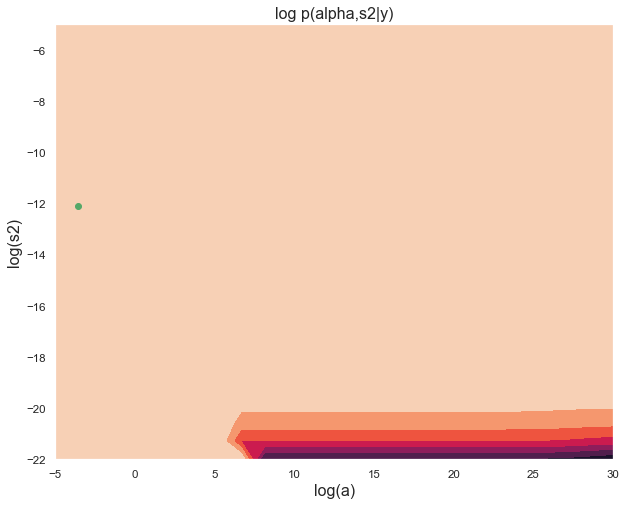

In [15]:
plt.figure(figsize=(10,8))
plt.contourf(log_alpha_values, log_s2_values, log_prob_y)
plt.scatter(most_prob_logalpha, most_prob_logs2, color='g')
plt.title('log p(alpha,s2|y)', fontsize=16), plt.xlabel('log(a)', fontsize=16), plt.ylabel('log(s2)', fontsize=16)
plt.show()

## Task 3 - Verify HMC on a simple Gaussian example

3. Familiarise yourself with the use of the Hamiltonian Monte Carlo (HMC) algorithm (Lecture
8), initially verifying the HMC implementation on a simple Gaussian example. [5 marks]

In [16]:
def energy_func(x, f):
    p0 = -x[0]**2/2
    p1 = -x[1]**2/2 + np.log(2+np.sin(f*x[1]))
    lgp = p0 + p1
    return -lgp

In [17]:
def energy_grad(x, f):
    g = np.empty(2)
    g[0] = x[0]
    g[1] = x[1] + f*np.cos(f*x[1]) / (2+np.sin(f*x[1]))
    return g

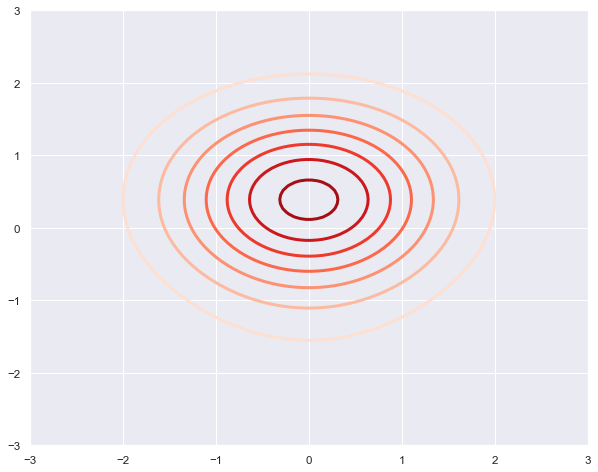

In [18]:
# Plotting parameters
f = 1
fsz = (10,8)
gsz = 100
lim = 3

gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, f)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [19]:
# Initial state: something random and sensible
x0 = np.random.normal(size=2)
hmc.gradient_check(x0, energy_func, energy_grad, 1)

Calc.         Numeric       Delta         Acc.
      1.5436        1.5436   7.483636e-11  11
   -0.788133      -1.52812  -7.399905e-01   1


Calc.         Numeric       Delta         Acc.
      1.5436        1.5436   7.483636e-11  11
   -0.788133      -1.52812  -7.399905e-01   1
|----------|  0% accepted [ 2 secs to go ]
|#---------| 81% accepted [ 2 secs to go ]
|##--------| 80% accepted [ 2 secs to go ]
|###-------| 80% accepted [ 2 secs to go ]
|####------| 80% accepted [ 1 secs to go ]
|#####-----| 80% accepted [ 1 secs to go ]
|######----| 80% accepted [ 1 secs to go ]
|#######---| 80% accepted [ 1 secs to go ]
|########--| 80% accepted [ 0 secs to go ]
|#########-| 80% accepted [ 0 secs to go ]
|##########| 80% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.03 / Accept=80.0%


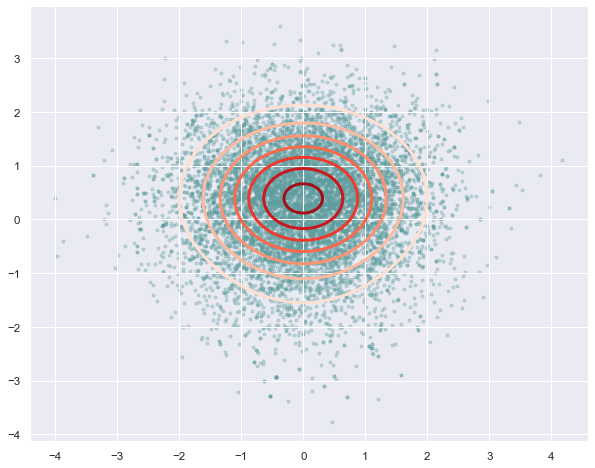

In [20]:
np.random.seed(seed=1)  # For reproducibility
R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 25  # OK here (should be larger in regression sampling)
eps = 0.03  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=True, args=[f])
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.3, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);